# Box-Jenkins Method Applied to the Inflation-Adjusted S&P 500


This notebook demonstrates the use of the Box-Jenkins method for time series model identification and parameter estimation. The time series is the inflation-adjusted monthly S&P 500 index for the years 1900 to 2017. 

This application of the Box-Jenkins method suggests that the times series is best modeled by an __ARIMA(2,1,0)__ process. The process is nonstationary, with a  autorgressive order of 2 in the differenced series most strongly indicated by the data, suggesting that monthly index level changes in the S&P 500 are most strongly dependent on the previous two months of index level changes (i.e. a quarter in the past). 


## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from pandas.plotting import autocorrelation_plot

## Parameters

In [2]:
DATA_DIR = "data/"
SP_DATA_FILE = "SP_500_(infl_adj_monthly_abridged).csv"

## Data Import

In [3]:
try:
    file_specifier_string = DATA_DIR + SP_DATA_FILE
    sp_data_df = pd.read_csv(file_specifier_string)
    
except:
    print("!!!!! Failed to load file %s !!!"%file_specifier_string)

Data reformatting:

In [4]:
sp_data_df["date"] = pd.to_datetime(sp_data_df["Date"])
sp_data_df = sp_data_df.reindex(index=sp_data_df.index[::-1]) # reverse row order
sp_data_df.set_index(["date"], inplace=True)

sp_data_df["value"] = sp_data_df["Value"]

sp_data_df = sp_data_df.drop(["Date","Value"], axis = 1)
sp_data_df.dropna(inplace=True)

# Box-Jenkins Method: Overview

The __Box-Jenkins method__ is composed of two primary tasks: 

1. __Model identification__ and determination of the degree of __stationarity__ of the time series. 
2. __Parameter estimation__ for the identified model. 

A more detailed outline of the method can be given as follows:

1. __Model Indentification__
    * Determine the degreee of __stationarity__ of the time series by calculating its __autocorrelation function (ACF)__. The behavior of the autocorrelation function indicates the type of time series model to be used. 
    
    | ACF Behavior| Model Indication |
    | ------------ | ---------------- |
    | Exponential decay| Autoregressive (AR) model|
    | Multiple impulses, otherwise zero   | Moving average (MA) model        |
    | Decay after a few lags | Autoregressive moving average (ARMA) model|
    | All zero or near zero | Random walk |
    | Periodic | Posseses seasonal components (e.g. GARCH model) | 
    | No decay or very slow decay| Non-stationary process | 
    
    * Many  ofthe possible models can be generalized as __autoregressive integrated moving average model (ARIMA)__ models, which are of the form:
    
$$ \left( 1- \sum^{p}_{i=1} \phi_{i} L^{i} \right) (1-L)^{d} X_t  = \left( 1 + \sum^{q}_{i=1} \theta_{i} L^{i} \right)\epsilon_t $$
    
*     Here, $L$ is the __lag__ operator. The shorthand for an ARIMA model is __ARIMA(p,d,q)__, where $p$ is the order of the autorgressive terms, $q$ is the order of the moving average terms, and $d$ is the order of integration (i.e. the number of times the time series has to be differenced to obtain an ARMA model). 
* Differencing the time series (i.e. adjusting $d$>0) is a method for removing non-stationary terms in the time series. 

* If the ACF indicates an ARIMA(p,d,q) model, determination of the orders of the autoregressive and moving average terms (p and q, respectively) can be determined through the use of the __partial autocorrelation function (PACF)__. The method for this determination follows:

  
| Indicated Model| ACF Behavior on Differenced Data | PACF Behavior on Differenced Data |
| ------------ | ---------------- |  ---------------- |
| ARIMA(p,d,0) |   Decaying exponential or sinusoidal | PACF shows impulse at lag $p$, but none beyond |
| ARIMA(0,d,q) | ACF shows impulse at lag $q$, but none beyond|   Decaying exponential or sinusoidal |



2. __Parameter Estimation__

    * Determine the model coefficients $\phi_i$ (autoregressive coefficients) and $\theta_i$ (moving average coefficents). 
    * For this task, algorithmic techniques are typically employed, including:
    
        * Maximum likelihood estimation (most common)
        * Nonlinear least squares regression
    
    


    

# S&P 500 Analysis

## ACFs for Raw and Differenced Time Series

In [5]:
N_differences = 4
sp_data_df["d_0"] = sp_data_df["value"]
for idx in range(1,N_differences+1):

    diffed_series = np.diff(sp_data_df["d_%d"%(idx-1)].to_numpy())
    sp_data_df["d_%d"%idx] = np.pad(diffed_series, (1,0),'constant', constant_values=(np.nan, np.nan))



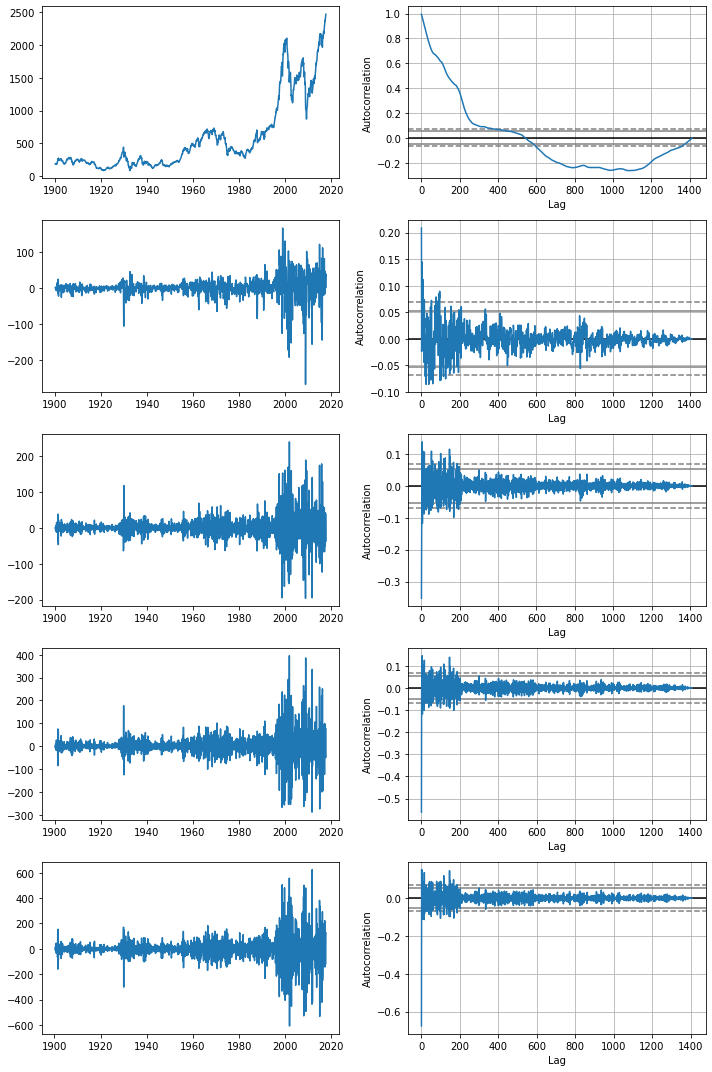

In [6]:

fig, axes = plt.subplots(N_differences+1, 2, figsize=(10, 15))


for idx in range(N_differences+1):
    axes[idx,0].plot(sp_data_df["d_%d"%idx].dropna())
    autocorrelation_plot(sp_data_df["d_%d"%idx].dropna(), axes[idx,1])
 
    
fig.tight_layout()
plt.show()

The horizontal lines denote the confidence bands of the correlation, with the dashed lines corresponding to 99% confidence. Thus the portion of the ACF above the upper dashed line represents positive correlation with 99% confidence.

The results of the ACFs suggest the following:

| Differencing Order| ACF Behavior| Model Indication |
| ------------ | ------------ | ---------------- |
| 0 | Decaying sinusoid, intercept at lag 600 months |  AR | 
| 1 | Decaying sinusoid, near 0 past lag 200 months, low confidence|  AR/random walk|
| 2 | Near 0, low confidence |  random walk| 
| 3 | Near 0, low confidence |  random walk| 
| 4 | Near 0, low confidence |  random walk| 

### Same Analysis on Partitioned Data: Pre-1990 and Post-1990



### Pre-1990

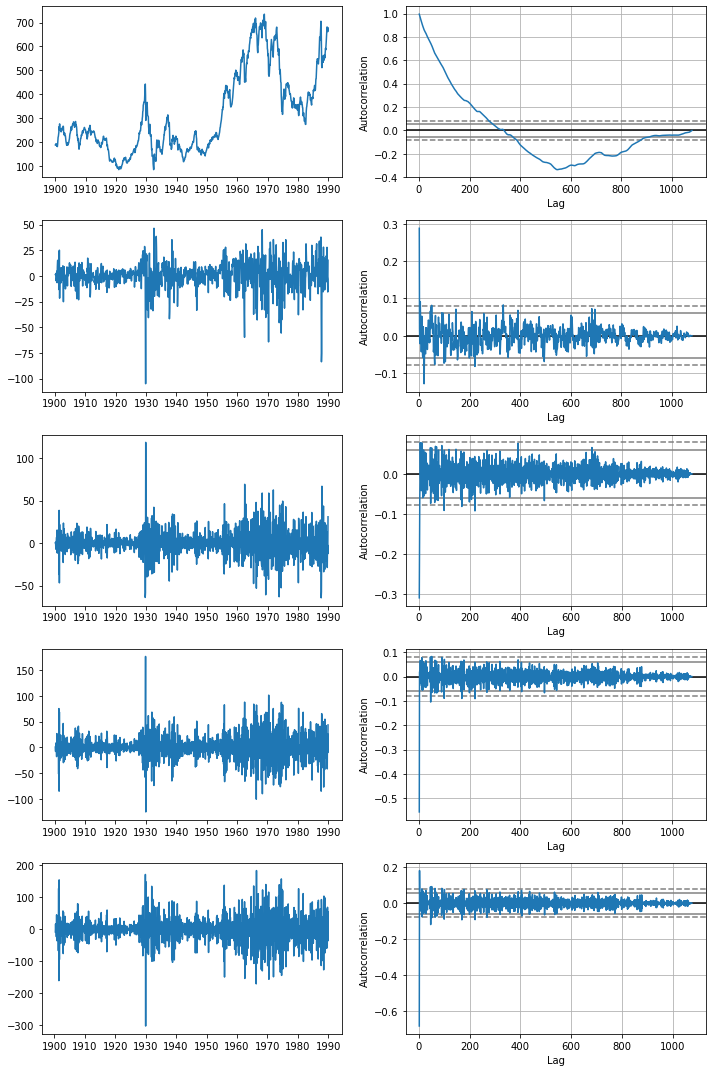

In [7]:
fig, axes = plt.subplots(N_differences+1, 2, figsize=(10, 15))

mask_post = sp_data_df.index >= '1990-01-01'
mask_pre = sp_data_df.index < '1990-01-01'


for idx in range(N_differences+1):
    axes[idx,0].plot(sp_data_df.loc[mask_pre,:]["d_%d"%idx].dropna())
    autocorrelation_plot(sp_data_df.loc[mask_pre,:]["d_%d"%idx].dropna(), axes[idx,1])
 
    
fig.tight_layout()
plt.show()


The results of the ACFs for the pre-1990 period suggest the following:

| Differencing Order| ACF Behavior| Model Indication |
| ------------ | ------------ | ---------------- |
| 0 | Decaying sinusoid, intercept at lag 350 months |  AR | 
| 1 | Decaying sinusoid, near 0 past lag 200 months, low confidence|  AR/random walk |
| 2 | Near 0, low confidence |  random walk| 
| 3 | Near 0, low confidence|  random walk| 
| 4 | Near 0, low confidence |  random walk| 

### Post-1990

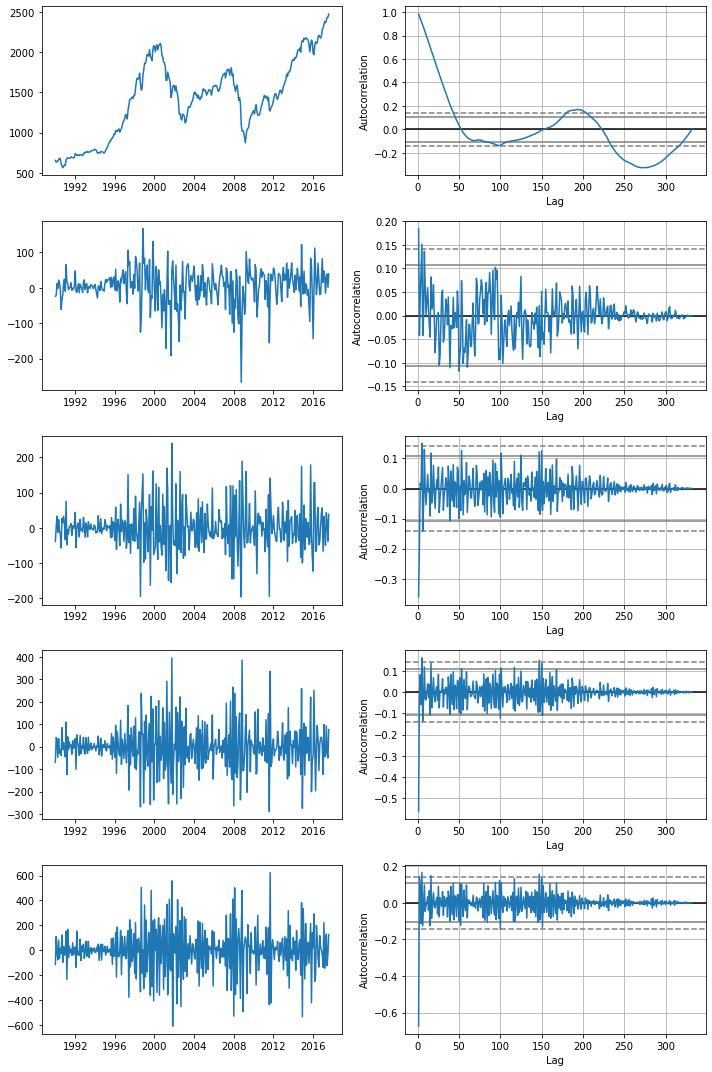

In [8]:
fig, axes = plt.subplots(N_differences+1, 2, figsize=(10, 15))

mask_post = sp_data_df.index >= '1990-01-01'
mask_pre = sp_data_df.index < '1990-01-01'


for idx in range(N_differences+1):
    axes[idx,0].plot(sp_data_df.loc[mask_post,:]["d_%d"%idx].dropna())
    autocorrelation_plot(sp_data_df.loc[mask_post,:]["d_%d"%idx].dropna(), axes[idx,1])
 
    
fig.tight_layout()
plt.show()

The results of the ACFs for the post-1990 period suggest the following:

| Differencing Order| ACF Behavior| Model Indication |
| ------------ | ------------ | ---------------- |
| 0 | Decaying sinusoid, intercept at lag 50 months |  AR | 
| 1 | Decaying sinusoid, near 0 past lag 200 months, low confidence|  AR/random walk |
| 2 | Near 0, low confidence |  random walk| 
| 3 | Near 0, low confidence|  random walk| 
| 4 | Near 0, low confidence |  random walk|

## Augmented Dickey-Fuller Stationarity Tests on the Several Time Series

The null hypothesis of the Augmented Dickey-Fuller test is that the time series contains a unit root, and it is therefore non-stationary. The p-value, as usual, is the probably of observing the sample data if the null hypothesis is true (i.e. non-stationary). If the ADF statistic is below a given critical value, one can reject the null hypothesis (i.e. non-stationarity) with the associated level of confidence. 

### Full sample

In [9]:
results = pd.DataFrame(columns = ["Series","ADF Statistic", "p-value","1% critical value", "5% critical value", \
                        "10% critical value", "Stationary with 90% Confidence"])


for idx in range(N_differences+1):
    adf_results= adfuller(sp_data_df["d_%d"%idx].dropna())
    append_dict = {"Series": idx,
                   "ADF Statistic": adf_results[0], 
                   "p-value":adf_results[1],
                   "1% critical value":adf_results[4]['1%'], 
                   "5% critical value":adf_results[4]['5%'], 
                    "10% critical value":adf_results[4]['10%'],
                    "Stationary with 90% Confidence": True if adf_results[0] <= adf_results[4]['10%'] else False}
    results = results.append(append_dict ,ignore_index =True)

In [10]:
results

,Series,ADF Statistic,p-value,1% critical value,5% critical value,10% critical value,Stationary with 90% Confidence
0,0,0.902719,9.931257e-01,-3.435063,-2.863622,-2.567878,False
1,1,-7.567446,2.900427e-11,-3.435063,-2.863622,-2.567878,True
2,2,-10.628566,5.286583e-19,-3.435080,-2.863629,-2.567882,True
3,3,-16.587200,1.812273e-29,-3.435084,-2.863631,-2.567883,True
4,4,-19.629936,0.000000e+00,-3.435087,-2.863632,-2.567884,True


### Pre-1990

In [11]:
results = pd.DataFrame(columns = ["Series","ADF Statistic", "p-value","1% critical value", "5% critical value", \
                        "10% critical value", "Stationary with 90% Confidence"])


for idx in range(N_differences+1):
    adf_results= adfuller(sp_data_df.loc[mask_pre,:]["d_%d"%idx].dropna())
    append_dict = {"Series": idx,
                   "ADF Statistic": adf_results[0], 
                   "p-value":adf_results[1],
                   "1% critical value":adf_results[4]['1%'], 
                   "5% critical value":adf_results[4]['5%'], 
                    "10% critical value":adf_results[4]['10%'],
                    "Stationary with 90% Confidence": True if adf_results[0] <= adf_results[4]['10%'] else False}
    results = results.append(append_dict ,ignore_index =True)

In [12]:
results

,Series,ADF Statistic,p-value,1% critical value,5% critical value,10% critical value,Stationary with 90% Confidence
0,0,-1.273876,6.410379e-01,-3.436453,-2.864235,-2.568205,False
1,1,-12.593693,1.798031e-23,-3.436453,-2.864235,-2.568205,True
2,2,-10.833001,1.689396e-19,-3.436564,-2.864283,-2.568231,True
3,3,-13.817136,8.030031e-26,-3.436569,-2.864286,-2.568232,True
4,4,-17.651551,3.718098e-30,-3.436575,-2.864289,-2.568234,True


### Post-1990

In [13]:
results = pd.DataFrame(columns = ["Series","ADF Statistic", "p-value","1% critical value", "5% critical value", \
                        "10% critical value", "Stationary with 90% Confidence"])


for idx in range(N_differences+1):
    adf_results= adfuller(sp_data_df.loc[mask_post,:]["d_%d"%idx].dropna())
    append_dict = {"Series": idx,
                   "ADF Statistic": adf_results[0], 
                   "p-value":adf_results[1],
                   "1% critical value":adf_results[4]['1%'], 
                   "5% critical value":adf_results[4]['5%'], 
                    "10% critical value":adf_results[4]['10%'],
                    "Stationary with 90% Confidence": True if adf_results[0] <= adf_results[4]['10%'] else False}
    results = results.append(append_dict ,ignore_index =True)

In [14]:
results

,Series,ADF Statistic,p-value,1% critical value,5% critical value,10% critical value,Stationary with 90% Confidence
0,0,-1.234204,6.587115e-01,-3.450759,-2.870530,-2.571560,False
1,1,-4.957752,2.688707e-05,-3.450695,-2.870502,-2.571545,True
2,2,-9.553667,2.532333e-16,-3.450823,-2.870558,-2.571575,True
3,3,-8.809083,2.014140e-14,-3.451349,-2.870789,-2.571698,True
4,4,-11.786112,1.007914e-21,-3.451215,-2.870730,-2.571666,True


### Conclusion

For both the full sample and the pre- and post-1990 partitions of sample, the ADF test indicates that the raw time series is non-stationary, but the differenced time series are very likely (99% confidence) stationary. 

This suggests an ARIMA(p,1,q) model for the the full sample.

## ARIMA Modeling on the Differenced (d=1) Time Series

### Full Sample

Before beginning a model-fitting procedure for the time series, one should re-examine the autocorrelation plot to determine candidate values for $p$ and $q$ in the ARIMA(p,1,q) model. 

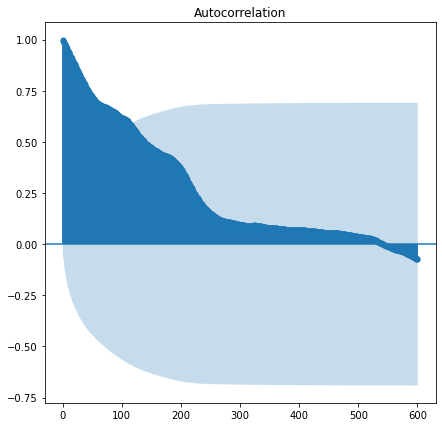

In [15]:
matplotlib.rc("figure", figsize=(7,7))
plot_acf(sp_data_df["d_%d"%0].dropna(), lags=600)
plt.show()

Examining the autocorrelation plot, one can see that a positive correlation exists for lags 0 through 520. The blue cone is the 95% confidence band, so 95% confidence of the correlations only exists up a lag of about 100. 

Let's examine the ACF on the differenced data:

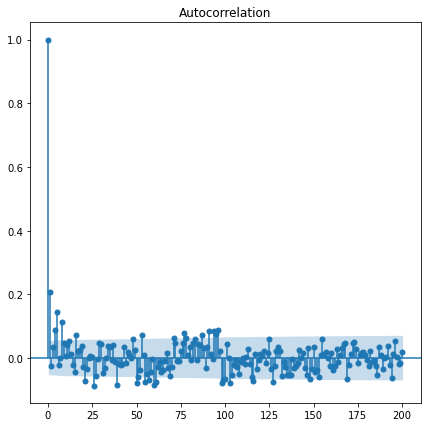

In [16]:
matplotlib.rc("figure", figsize=(7,7))
plot_acf(sp_data_df["d_%d"%1].dropna(), lags=200)
plt.show()

One can observe an ACF with the decaying exponential of an ARIMA(p,d,0) model, with positive correlations up to a lag of roughly 10. 

Let's examine the PACF of the of the differenced data:

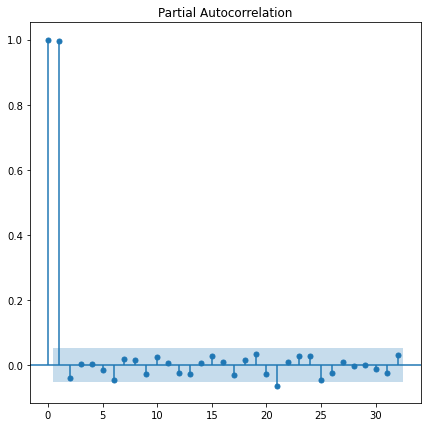

In [17]:
matplotlib.rc("figure", figsize=(7,7))
plot_pacf(sp_data_df["d_%d"%0].dropna())
plt.show()

The last strong impulse is at lag 2, with insignificant correlations beyond, indicating that $p=2$ is a good candidate. 

### ARIMA Model Fitting and Diagnostics

In [18]:
model = ARIMA(sp_data_df["d_%d"%0].dropna(), order=(2,1,0))
model_fit = model.fit()

/Users/stuarttruax/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/stuarttruax/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/stuarttruax/opt/anaconda3/envs/tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                    d_0   No. Observations:                 1412
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6616.365
Date:                Sat, 25 Jun 2022   AIC                          13238.731
Time:                        11:59:11   BIC                          13254.487
Sample:                             0   HQIC                         13244.618
                               - 1412                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2260      0.014     15.723      0.000       0.198       0.254
ar.L2         -0.0680      0.014     -4.988      0.000      -0.095      -0.041
sigma2       693.5016      9.102     76.188      0.0

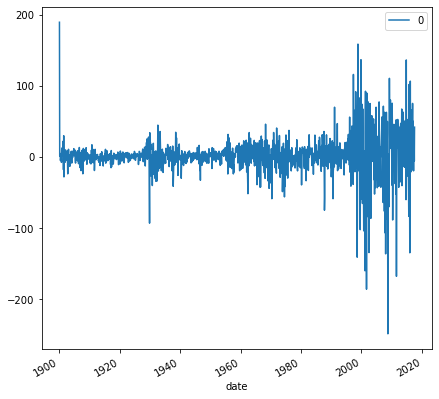

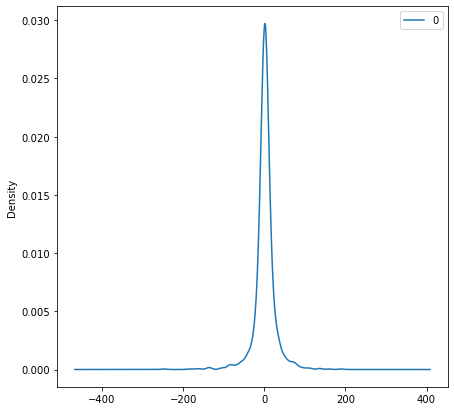

                 0
count  1412.000000
mean      1.498851
std      26.751306
min    -248.674800
25%      -6.010223
50%       1.850889
75%       9.601045
max     189.140000


In [19]:
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

# Conclusion


The application of the Box-Jenkins method suggests that the times series is best modelled by an __ARIMA(2,1,0)__ process. 

Examining the diagnostics of the ARIMA(2,1,0) model fit, one finds a mean of 1.49 in the residuals. This suggests that there is a bias in the model. 

The residual plot also shows an explosion in the variance of the residuals post-1990, suggesting that two separate models should be fitted to the pre- and post-1990 partitions of data. 

The Ljung-Box probability is 0.95, which is suggests the residuals are independent, which indicates model correctness. The Jarque-Bera statistic, however, suggests the residuals are far from normally distributed.

Adjusting the $p$ parameter in the ARIMA(p,1,0) model only worsens the results and degrades the diagnostics, suggesting that a 2-lag autorgressive components is most strongly indicated by the data.

### Nonstationarity and Randomness of Monthly Level Changes

Some reasonable results were obtained from an ARIMA(2,1,0) model fit. The ADF tests and ACFs of the differenced data indicate the raw __S&P 500 to be nonstationary__, both in the full sample in the partitioned samples. That is, for the S&P 500 time series $X_t$:

$$E[X_t] = \mu_x(t)$$

That is, the expectation of any monthly $X_t$ is a function of time (i.e. the level of the S&P 500 is shifting with time, e.g. due to a drift component). Given that the data is inflation-adjusted, this implies that underlying economic growth and changing productivity may be responsible for this result. 

Removing the non-stationary component of the time series,  the monthly price change (obtained from the first difference of the raw time series), is revealed to either be __random__, or have at most a __2-month autoregressive component__. This suggest that instantaneous monthly index level changes have a dependence on _at most_ the last quarter of monthly index level changes.  

# References:

__References__:

[1] https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

[2] https://medium.com/analytics-vidhya/can-lstms-predict-stock-prices-a-complete-analysis-part-1-d9409451216d

[3] https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

[4] P.J. Brockwell, R.A. Davis, _Introduction to Time Series and Forecasting_, Springer, New York, 2002

[5] https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

[6] https://en.wikipedia.org/wiki/Autoregressive_model#/media/File:AutocorrTimeAr.svg

[7] https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html